## 1. Scrapping the data

In [1]:
import time
import datetime

import requests
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.keys import Keys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

In [2]:
project_list_url = 'https://www.pik.ru/projects'
flat_url_base = 'https://www.pik.ru/search'
webdriver_path = 'C:\\Users\\petr\\Desktop\\dev\\_PROJECTS\\pik_scrapy\\web_driver\\chromedriver.exe'
data_path = '.\\data\\'

In [3]:
def get_project_list():
    project_page = requests.get(project_list_url)
    project_soup = BeautifulSoup(project_page.content, 'lxml')
    project_body = project_soup.body
    project_list = list()

    for a in project_body.find_all('a', attrs={'target': '_self'}):
        try:
            href = a['href']
            address = a.find('h6').text
            metro_name = a.find('span', attrs={'type': 'subTitleTwo'}).text
            try:
                metro_type = a.contents[2].div.div.contents[1].div.div.div.div.div.div['type']
            except (AttributeError):
                metro_type = a.contents[2].div.div.contents[1].div.contents[0].div.div['type']
            metro_time = a.contents[2].div.div.contents[1].div.span.text
            project_list.append([href, address, metro_name, metro_type, metro_time])
        except (AttributeError):
            pass
        
    return project_list    # python list of all projects data

In [4]:
def get_flat_list(project_flat_url):
    flat_url = flat_url_base + project_flat_url
    
    driver = webdriver.Chrome(executable_path = webdriver_path)
    driver.get(flat_url)
    
    try:
        time.sleep(5)
        html = driver.find_element_by_tag_name('html')
        html.send_keys(Keys.END)
        time.sleep(20)
    finally:
        page = driver.page_source
        driver.quit()
        flat_list_page = BeautifulSoup(page, 'lxml')
        flat_list = flat_list_page.body.find_all('a', {'class':'sc-erNlkL PtqKj'})
        
    return flat_list

In [5]:
def get_flat_data(flat_list):
    flat_data = list()
    
    for flat in flat_list:
    
        # get main features
        url = flat['href']
        location = flat.find('span', {'class': 'sc-bdVaJa eXgwJJ Typography'}).text
        location_list = location.split(', ')
        section = location_list[-2]
        floor = location_list[-1]
        if len(location_list) == 3:
            building = location_list[0]
        elif len(location_list) > 3:
            building = ', '.join(location_list[:-2])
        else:
            section, floor, building = ('-', '-', '-')
        
        rooms, area, _ = flat.find('h6', {'class': 'sc-bdVaJa lbeMBz Typography'}).text.split(' ')
        move_in = flat.find('span', {'class': 'sc-bdVaJa bDJwwA Typography'}).text
    
        # get finish and offer features
        try:
            finish = flat.find('span', {'class': 'sc-bdVaJa eMLNis Typography'}).text
        except (AttributeError):
            finish = '-'
    
        try:
            no_finish = flat.find('span', {'class': 'sc-bdVaJa gYqfvK Typography'}).text
        except (AttributeError):
            no_finish = '-'
        
        try:
            low_mortgage = flat.find('span', {'class': 'sc-bdVaJa kygNff Typography'}).text
        except (AttributeError):
            low_mortgage = '-'
        
        try:
            old_price = flat.find('span', {'class': 'sc-bdVaJa fdtYeV Typography'}).text
        except (AttributeError):
            old_price = '-'
        
        # get price
        price = flat.find('span', {'type': 'subTitleOne'}).text
        
        flat_data.append([url, location, building, section, floor, rooms, area,
                          move_in, finish, no_finish, low_mortgage, old_price, price])
        
    return flat_data

In [180]:
projects = get_project_list()
project_links = [project[0] for project in projects]

all_flat_data = pd.DataFrame([], columns = ['url', 'location','building', 'section', 
                                          'floor', 'rooms', 'area', 'move_in', 'finish', 
                                          'no_finish', 'low_mortgage', 'old_price', 'price'])

for link in project_links:
    flat_list = get_flat_list(link)
    flat_data = pd.DataFrame(get_flat_data(flat_list),
                             columns = ['url', 'location', 'building', 'section',
                                        'floor', 'rooms', 'area', 'move_in', 'finish',
                                        'no_finish', 'low_mortgage', 'old_price', 'price'])
    
    all_flat_data = pd.concat([all_flat_data, flat_data])
    print(link, len(flat_data), len(all_flat_data))

/perovo2 139 139
/kron14 171 310
/sp 417 727
/lublinpark 324 1051
/hp 158 1209
/luga 234 1443
/zhulebino 509 1952
/gp 284 2236
/rustaveli 172 2408
/mp 502 2910
/ilmen 405 3315
/s16 240 3555
/kk15 86 3641
/dp 331 3972
/nh15 219 4191
/sher 90 4281
/volp 110 4391
/il-luga 375 4766
/bpark 113 4879
/kron9 117 4996
/2ngt 190 5186
/lyubpark 535 5721
/bp2 308 6029
/myakinino 89 6118
/polar 188 6306
/luberecky 280 6586
/port 51 6637
/mkr-vostochnoe-butovo 301 6938
/zhiloi-raion-yaroslavskii 111 7049
/sles 100 7149
/apavlova 186 7335
/i-les 397 7732
/lp 93 7825
/bd 336 8161
/bo2 351 8512
/park 316 8828
/amur 344 9172
/ba85 111 9283
/v24 292 9575
/kuzminskyles 238 9813
/mitino 57 9870
/prostor 181 10051
/molodgvar 51 10102
/spolyany 241 10343
/yasen 134 10477
/mkrn-putilkovo 94 10571
/odin 56 10627
/mles 71 10698
/spark 45 10743
/iz11 49 10792
/rk11 2 10794
/pearl-zelenograd 6 10800
/les 3 10803
/vanderpark 1 10804
/vlublino 3 10807
/ap 1 10808
/pv21 1 10809


In [182]:
all_flat_data.to_csv(data_path + 'flats.csv')

In [186]:
project_data = pd.DataFrame(projects, columns = ['project', 'address', 'metro_name', 'metro_type', 'metro_time'])
project_data.to_csv(data_path + 'projects.csv')

## 2. Data transformation

### 2.1. flats dataset

In [9]:
flat_ds = pd.read_csv(data_path + 'flats.csv').drop(columns=['Unnamed: 0'])

flat_ds.replace(to_replace = '-', value = np.NaN, inplace = True)

In [4]:
# convert numeric features to number types
flat_ds['price'] = flat_ds['price'].apply(lambda x: x[:-2].replace(' ', '')).astype('int64')
flat_ds['project'] = flat_ds['url'].apply(lambda x: '/' + x.split('/')[1])
flat_ds['floor'] = flat_ds['floor'].apply(lambda x: x.split(' ')[0]).astype('int64')
flat_ds['area'] = flat_ds['area'].apply(lambda x: x.replace(',', '.')).astype('float')

# get room number
replacement_room = {'Студия': '0',
                    'Однокомнатная': '1',
                    'Однокомнатные': '1',
                    'Двухкомнатная': '2',
                    'Двухкомнатные': '2',
                    'Трехкомнатная': '3',
                    'Трехкомнатные': '3',
                    'Четырехкомнатная': '4',
                    'Пятикомнатная': '5'}
flat_ds['rooms'] = flat_ds.rooms.replace(replacement_room).astype('int64')

# extract months to move in and create ready_flat flag from move_in feature
coladd_move_in_list = flat_ds['move_in'].apply(lambda x: x.replace('Заселение до ', '').split(' '))
flat_ds.insert(8, 'move_in_list', coladd_move_in_list)
coladd_ready_flat = [1 if len(x) < 3 else 0 for x in flat_ds['move_in_list']]
flat_ds.insert(9, 'ready_flat', coladd_ready_flat)
replacement_move = {'января': 1,
                    'февраля': 2,
                    'марта': 3,
                    'апреля': 4,
                    'мая': 5,
                    'июня': 6,
                    'июля': 7,
                    'августа': 8,
                    'сентября': 9,
                    'октября': 10,
                    'ноября': 11,
                    'декабря': 12}

mask_not_ready = flat_ds['ready_flat'] == 0
coladd_day = flat_ds.loc[mask_not_ready, 'move_in'].apply(lambda x: int(x.replace('Заселение до ', '').split(' ')[0]))
coladd_month = flat_ds.loc[mask_not_ready, 'move_in'].apply(lambda x: x.replace('Заселение до ', '').split(' ')[1])
coladd_month = coladd_month.replace(replacement_move)
coladd_year = flat_ds.loc[mask_not_ready, 'move_in'].apply(lambda x: int(x.replace('Заселение до ', '').split(' ')[2]))
flat_ds.insert(10, 'move_in_day', coladd_day)
flat_ds.insert(11, 'move_in_month', coladd_month)
flat_ds.insert(12, 'move_in_year', coladd_year)

flat_ds['move_in_date'] = flat_ds['move_in_year'] * 10000 + flat_ds['move_in_month'] * 100 + flat_ds['move_in_day']
flat_ds['move_in_date'].fillna(value=20210109, inplace = True)
flat_ds['move_in_date'] = flat_ds['move_in_date'].astype('int64').astype('str')
flat_ds['move_in_date'] = flat_ds['move_in_date'].apply(lambda x: datetime.date(day = int(x[-2:]),
                                                                                month = int(x[4:6]),
                                                                                year = int(x[:4])))
addcol_wait = flat_ds['move_in_date'].apply(lambda x: round((x - datetime.date(2021, 1, 9)).days / 30.4167, 0))
flat_ds.insert(13, 'wait_to_move', addcol_wait)

# binaries and dummies
flat_ds['finish_full'] = [1 if x == 'Отделка' else 0 for x in flat_ds['finish'].to_numpy()]
flat_ds['finish_whitebox'] = [1 if x == 'Отделка WhiteBox' else 0 for x in flat_ds['finish'].to_numpy()]

flat_ds['old_price'].fillna(value = 0, inplace=True)
flat_ds['old_price'] = flat_ds['old_price'].replace({'Цена 2020 года': 1}).astype('int64')
flat_ds['low_mortgage'].fillna(value = 0, inplace = True)
flat_ds.loc[flat_ds['low_mortgage'] != 0, 'low_mortgage'] = 1
flat_ds['low_mortgage'] = flat_ds['low_mortgage'].astype('int64')


# drop useless columns
flat_ds.drop(columns = ['move_in_day', 'move_in_month', 'move_in_year',
                        'move_in_list', 'move_in', 'location', 'building',
                        'section', 'no_finish', 'finish', 'move_in_date', 'url', 'ready_flat'], inplace = True)

In [5]:
# reorder columns
flat_ds = flat_ds[['floor', 'rooms', 'area', 'wait_to_move', 'low_mortgage', 'old_price', 
                   'finish_full', 'finish_whitebox', 'price', 'project']]

In [6]:
flat_ds.head(5)

,floor,rooms,area,wait_to_move,low_mortgage,old_price,finish_full,finish_whitebox,price,project
0,3,3,78.4,32.0,0,0,1,0,13806240,/perovo2
1,33,3,78.7,32.0,0,0,1,0,14386360,/perovo2
2,30,2,49.0,32.0,0,0,1,0,9981300,/perovo2
3,13,1,34.6,32.0,0,0,1,0,7217560,/perovo2
4,18,2,46.3,32.0,0,0,1,0,9611880,/perovo2


### 2.2 Projects dataset

In [10]:
project_ds = pd.read_csv(data_path + 'projects.csv').drop(columns=['Unnamed: 0'])

In [8]:
# appartments
apartment_names = ['Пресненский вал 21', 'Солнцево парк', 'Волоколамское 24']
project_ds['apparts'] = [1 if x in apartment_names else 0 for x in project_ds['address']]

# time from circle
project_ds['time_to_center'] = [28,18,31,30,21,50,33,21,9,33,21,18,10,
                                21,32,14,25,13,25,18,11,39,34,19,20,39,
                                16,34,22,36,19,18,10,33,25,33,18,28,33,33,38,
                                15,19,45,29,27,13,40,42,18,18,40,32,19,27,31,6]

# time to metro on foot / bus 
project_ds['metro_time'] = project_ds['metro_time'].apply(lambda x: x.split(' ')[0]).astype('int64')
project_ds['metro_walk'] = [1 if x == 'walkingMan' else 0 for x in project_ds['metro_type']]
project_ds['metro_walk'] = project_ds['metro_walk'].astype('int64')

# onehot metro station name
onehot_station = pd.get_dummies(project_ds['metro_name'], prefix = 'st')
project_ds = project_ds.merge(onehot_station, how='inner', left_index = True, right_index = True)


# drop unused features
project_ds.drop(columns=['address', 'metro_type', 'metro_name'], inplace = True)

In [9]:
project_ds.head(5)

,project,metro_time,apparts,time_to_center,metro_walk,st_Авиамоторная,st_Аннино,st_Б-р Дмитрия Донского,st_Бабушкинская,st_Ботанический сад,...,st_Стрешнево,st_Строгино,st_Сходненская,st_Текстильщики,st_Улица 1905 года,st_Улица Скобелевская,st_Филатов луг,st_Фили,st_Ховрино,st_Черкизовская
0,/perovo2,7,0,28,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,/kron14,9,0,18,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/sp,5,0,31,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,/lublinpark,15,0,30,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,/hp,5,0,21,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3 Merge

In [10]:
data = flat_ds.merge(project_ds, how = 'left', on = 'project')
data.drop(columns = 'project', inplace = True)

In [11]:
# we'll need these lists later when we preprocess numeric variables
f_binary = ['low_mortgage', 'old_price', 'finish_full', 
         'finish_whitebox', 'apparts', 'metro_walk'] + [x for x in data.columns[13:]] # all station_name features
f_numeric = set(data.columns) - set(f_binary)

## 3. Exploratory

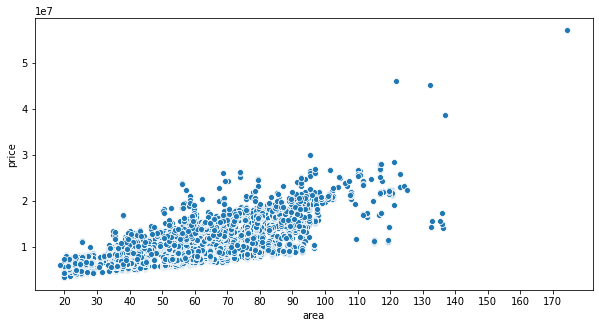

In [12]:
plt.figure(figsize = (10,5))
plt.xticks(np.arange(10, 180, 10), np.arange(10, 180, 10))
sns.scatterplot(data = data, x = 'area', y = 'price')

I definitely dilike these four outliers in top right corner: expensive flats likely have their specifics and it's pointless to include them into data.

In [13]:
data = data[data['price'] < 35000000]     # deleting too expensive flats
data.drop(columns = 'st_Улица 1905 года', inplace = True) # now this location is empty

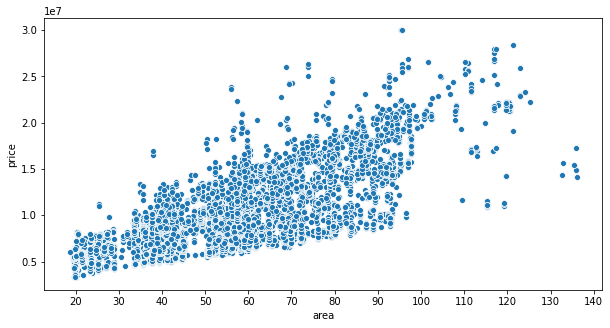

In [14]:
plt.figure(figsize = (10,5))
plt.xticks(np.arange(10, 180, 10), np.arange(10, 180, 10))
sns.scatterplot(data = data, x = 'area', y = 'price')

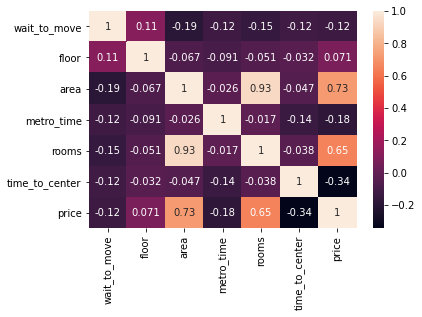

In [15]:
corrs = data[f_numeric].corr()
sns.heatmap(corrs, annot = True)

It seems like it's time to delete rooms cause they strongly correlated with area. Why not delete area instead? Because it posess more information (equal room flats may differ by area). Implicitly it justified with greater correlation coefficient with target variable (price).

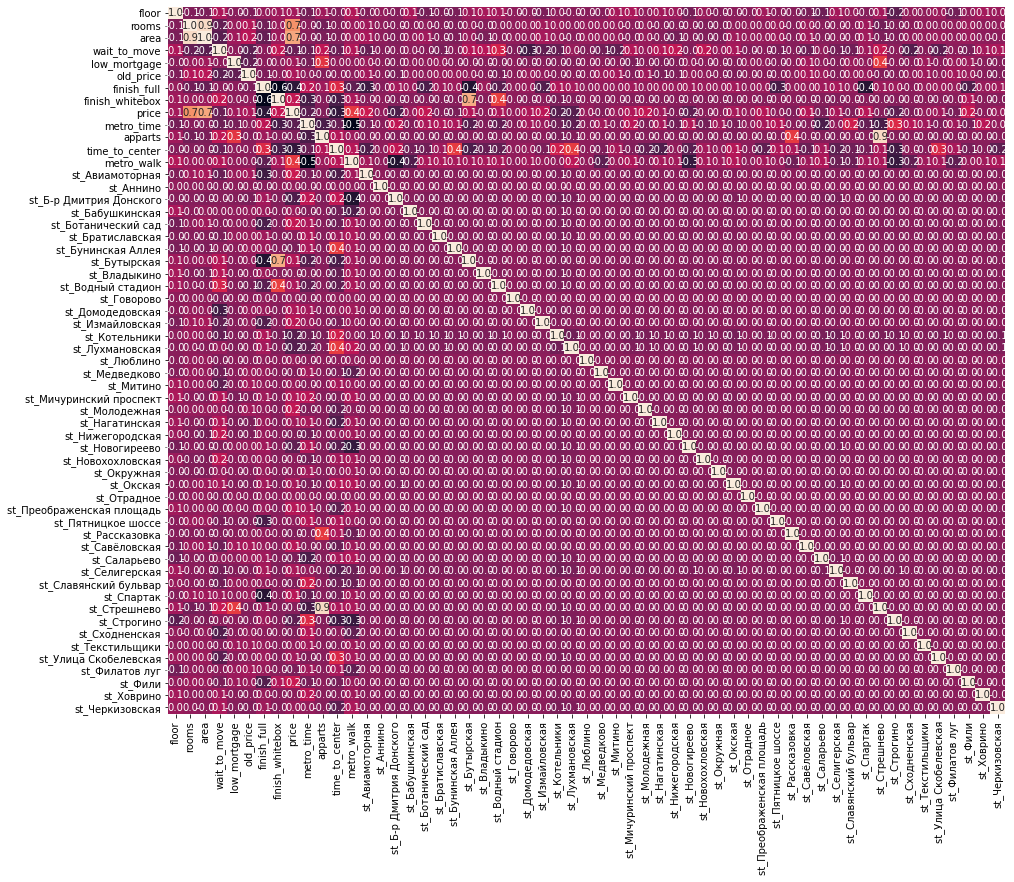

In [16]:
all_corr = data.corr()
fig = plt.figure(figsize=(15,13))
sns.heatmap(data = all_corr, cbar = False, annot = True, fmt = '.1f')

st_Стрешнево + appart and st_Бутырская + finish_whitebox are next suspects. They are correlated pairwise.

In [17]:
data[['st_Стрешнево', 'apparts', 'st_Бутырская', 'finish_whitebox']].corrwith(data['price'])

st_Стрешнево      -0.030354
apparts           -0.046716
st_Бутырская       0.126185
finish_whitebox    0.188548
dtype: float64

st_Стрешнево and st_Бутырская must go then (because their correlations weaker than ones of their opponents)

In [18]:
data.drop(columns = ['rooms', 'st_Стрешнево', 'st_Бутырская'], inplace = True)

"This multicollinearity testing means something" - said Winnie-the-Pooh to himself. The first method is doomed to be OLS regression.

## 4. Modelling

### 4.1. Task A: betas' importance

Now I wonder what factors are most closely related to flat price. So for now there'll be no messy-messy training-validation-testing.

In [19]:
X = data.copy().drop(columns = ['price'])
y = data['price']

In [20]:
%%time
model = sm.OLS(endog = y, exog = sm.add_constant(X))
result = model.fit()

Wall time: 63 ms


In [21]:
print(result.summary2())

                                Results: Ordinary least squares
Model:                       OLS                       Adj. R-squared:              0.943      
Dependent Variable:          price                     AIC:                         327351.4894
Date:                        2021-01-19 22:06          BIC:                         327737.7409
No. Observations:            10805                     Log-Likelihood:              -1.6362e+05
Df Model:                    52                        F-statistic:                 3445.      
Df Residuals:                10752                     Prob (F-statistic):          0.00       
R-squared:                   0.943                     Scale:                       8.3737e+11 
-----------------------------------------------------------------------------------------------
                              Coef.       Std.Err.     t     P>|t|      [0.025        0.975]   
------------------------------------------------------------------------

In [22]:
# delete siefficients with high p_values
pvalues = pd.DataFrame(result.pvalues.sort_values(ascending = False), columns = ['p_value'])
params = pd.DataFrame(result.params, columns = ['coef'])

coefs = params.merge(pvalues, how = 'left', left_index = True, right_index = True)
coefs = coefs[coefs['p_value'] < 0.05]
coefs.coef = coefs.coef.astype('int64')

coefs_general = coefs.iloc[:12, :].sort_values(by = 'coef', ascending = False)
coefs_stations = coefs.iloc[12:, :].sort_values(by = 'coef', ascending = False)

coefs = pd.concat([coefs_general, coefs_stations])

In [23]:
coefs

,coef,p_value
const,5925047,1.087497e-160
finish_whitebox,1309653,1.445653e-26
metro_walk,701890,1.301422e-34
finish_full,549135,7.157789e-14
area,124537,0.000000e+00
floor,13729,3.112449e-32
wait_to_move,-49120,2.976520e-147
low_mortgage,-65766,3.952374e-02
time_to_center,-69117,5.525388e-31
metro_time,-71724,1.970130e-75


There're some outcomes of the model:
1. Spherical PIK flat in Moscow vacuum costs around 5.9 mln. rub. This flat has no area, no floor and is located right in the middle of nowhere. So it's more interesting to look at coefficients of other features.
2. Full PIK's finish costs about +550 000 rub vs flats with no finish at all. Whitebox finish here adds 1 300 000 rub. Although it's cheaper than full finish, it's possibly used in some good location and expensive projects, so OLS attributes part of this high price to the whitebox finish.
3. Ability to go to a nearest metro station on foot adds about 700 000 rub. to the price (vs the need to ride a bus to get to a metro station).
4. Each square meter of area costs about 125 000 rub. Looks not so accurate, but a part of meter price included into constant.
5. If you want the flat to be one floor higher, you pay additional 14 000 rub.
6. Each month of waiting your flat to be finished decreases the price by about 50 000 rub.
7. If you wanna spend 1 minute less on your way to central ring on metro, get ready to pay additional 70 000 rub. for each minute.
8. About the same 70 000 rub. you pay for walking for 1 minute less to nearest metro station.
9. Appartments cost less than flats (-320 000 rub.), but since appartments has specific location themselves, this literaly means nothing.
10. The most juicy projects are located near Фили, Измайловская, Ботанический сад, Авиамоторная, Молодежная. In turn, Новогиреево, Строгино, Лухмановская, Б-р Дмитрия Донского and Котельники are not that attractive.